In [1]:
import pandas as pd
import numpy as np
import os
import pyaddmalts as pmp
from util import CATE
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pickle as pkl

In [2]:
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 30})
plt.rcParams.update({'font.family': 'Arial'})
plt.rcParams["figure.figsize"] = (10,5)

In [3]:
data_tables_directory = './cgm_analysis/RT-CGM Randomized Clinical Trial/DataTables'

In [4]:
hba1c = pd.read_csv(data_tables_directory + '/tblALabHbA1c.csv')

In [5]:
demographic_data = pd.read_csv(data_tables_directory + '/tblAPtSummary.csv')
demographic_data['Treatment'] = (demographic_data['TxGroup'] == 'RT-CGM').astype(int).values
demographic_data['Male'] = (demographic_data['Gender'] == 'M')
demographic_data['NonHispanicWhite'] = (demographic_data['Ethnicity'] == 'Not Hispanic or Latino') * (demographic_data['Race'] == 'White')
demographic_data['EduCollegeGrad'] = demographic_data['EduCareGvrPEdu'].isin(['Bachelors', 'Masters', 'Professional'])
demographic_data['NumSevHypo'] = demographic_data['NumSevHypo'].apply(lambda x: 3 if (x == '>3') else int(x))
demographic_data['SevHypo'] = (demographic_data['NumSevHypo'] >= 1)
demographic_data = demographic_data.sort_values('PtID')

demographic_data = hba1c.query('Visit == "Randomization"').merge(demographic_data,
                                              left_on = 'PtID',
                                              right_on = 'PtID', 
                                              how = 'right')
demographic_data['low_baseline_hba1c'] = (demographic_data['LabA1cResult'] < 7.0).values
demo_cols = ['Male', 'AgeAsOfRandDt', 'NonHispanicWhite', 'DurDiabetes', 'EduCollegeGrad', 'SevHypo', 'Treatment', 'low_baseline_hba1c']
demographic_data_ptid = demographic_data.copy()
demographic_data = demographic_data[demo_cols]

demographic_data_ptid['week26_date'] = pd.to_datetime(demographic_data_ptid['RandDt']) + pd.DateOffset(26 * 7)
demographic_data_ptid['week27_date'] = pd.to_datetime(demographic_data_ptid['RandDt']) + pd.DateOffset(27 * 7) 

In [6]:
def in_range(x, low = 71, high = 180):
    return np.mean((x >= low) * (x <= high))
qtl_grid = np.linspace(0, 1, 900)
def make_y_qtl_fn(filename, qtl_grid = qtl_grid, post_treatment = True):
    df = pd.read_csv(filename)
    if post_treatment:
        df['time'] = pd.to_datetime(df['DeviceDtTm'])
        if 'Baseline' not in filename:
            # find all the patients who have at least 26 weeks worth of data
            df = df.merge(demographic_data_ptid[['PtID', 'week26_date', 'week27_date']], on = 'PtID', how = 'inner')
            df = df.query('time >= week27_date')
    y1 = []
    y_mean = []
    y_range = []
    for i in df.PtID.unique():
        y1.append(np.quantile(df.query(f'PtID == {i}').Glucose.values, qtl_grid))
        y_mean.append(df.query(f'PtID == {i}').Glucose.values.mean())
        y_range.append(in_range(df.query(f'PtID == {i}').Glucose.values))
    y1 = np.array(y1)
    y_mean = np.array(y_mean)
    y_range = np.array(y_range)

    return df.PtID.unique(), y1, y_mean, y_range

def make_density_plot(filename, i):
    cgm_df1 = pd.read_csv(filename)
    plot = cgm_df1.groupby('PtID')['Glucose'].plot.kde(xlim = (0, 550))
    return plot

In [7]:
cgm_matrix_ptid = []
y = []
y_mean = []
y_range = []

for i in range(1, 13):
    index1, y1, y_mean1, y_range1 = make_y_qtl_fn(data_tables_directory + '/tblADataRTCGM_Unblinded_RTCGMGroup_' + str(i) + '.csv')
    cgm_matrix_ptid.append(index1)
    y.append(y1)
    y_mean.append(y_mean1)
    y_range.append(y_range1)

# index1, y1, y_mean1, y_range1 = make_y_qtl_fn(data_tables_directory + '/tblADataRTCGM_Blind_ControlGroup.csv')
for i in range(1,6):
    index1, y1, y_mean1, y_range1 = make_y_qtl_fn(data_tables_directory + '/tblADataRTCGM_Unblinded_ControlGroup_' + str(i) + '.csv')
    cgm_matrix_ptid.append(index1)
    y.append(y1)
    y_mean.append(y_mean1)
    y_range.append(y_range1)

cgm_matrix_ptid = np.hstack(cgm_matrix_ptid)
y = np.vstack(y)
y_mean = np.hstack(y_mean)
y_range = np.hstack(y_range)


In [8]:
# process baseline data
baseline_data = pd.read_csv(data_tables_directory + '/tblADataRTCGM_Blind_Baseline.csv')
baseline_data = baseline_data.\
    sort_values('PtID').\
        merge(pd.DataFrame({'PtID' : cgm_matrix_ptid}), 
              left_on='PtID', 
              right_on='PtID', 
              how = 'right')

In [9]:
def percent_in_range(x):
    return np.intersect1d(np.where(x[x >= 70])[0], np.where(x[x <= 180])).shape[0]/x.shape[0]
baseline_data['rec_number'] = baseline_data.assign(x = 1).groupby('PtID')['x'].cumsum()
baseline_matrix = baseline_data.pivot_table(values = 'Glucose', index = 'PtID', columns = 'rec_number')
Q_x = np.apply_along_axis(func1d = lambda x: np.quantile(a = x[x == x], 
                                                   q = qtl_grid), 
                                                   arr = baseline_matrix.to_numpy(), axis = 1)
Q_x = Q_x.reshape(Q_x.shape[0], 1, Q_x.shape[1])
baseline_mean = np.apply_along_axis(func1d = lambda x: np.mean(x[x == x]), 
                                                   arr = baseline_matrix.to_numpy(), axis = 1)
baseline_tir = np.apply_along_axis(func1d = in_range, arr = baseline_matrix.to_numpy(), axis = 1)

In [10]:
# filter demographic data so it's just units for whom we have data
demographic_data = demographic_data_ptid.loc[demographic_data_ptid.PtID.isin(cgm_matrix_ptid), ]
demographic_data = demographic_data[demo_cols]

In [11]:
np.random.seed(999)
n_units = demographic_data.shape[0]
train_indexes = np.random.choice(n_units, size = int(0.2 * n_units), replace = False)
est_indexes = list(set(range(n_units)) - set(train_indexes))
X_train = demographic_data.iloc[train_indexes, :].reset_index().drop('index', axis = 1)
X_est = demographic_data.iloc[est_indexes, :].reset_index().drop('index', axis = 1)
y_train = y[train_indexes, :]
y_est = y[est_indexes, :]
Q_x_train = Q_x[train_indexes, :]
Q_x_est = Q_x[est_indexes, :]

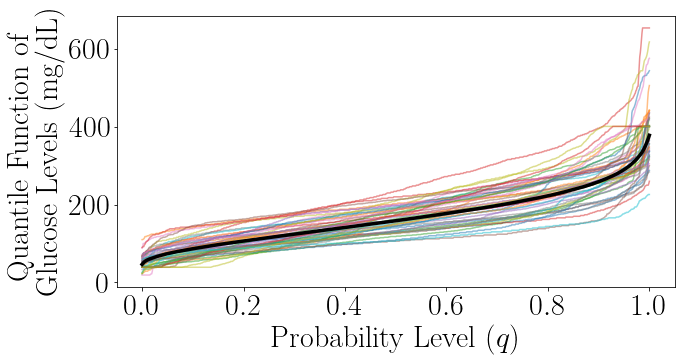

In [12]:
for i in range(50):
    plt.plot(qtl_grid, Q_x[i, 0, :], alpha = 0.5)

plt.plot(qtl_grid, Q_x[:, 0, :].mean(axis = 0), linewidth = 3.5, color = 'black')

plt.xticks(fontsize = 30)
plt.yticks(fontsize = 30)

plt.xlabel(r'Probability Level ($q$)', size = 30, weight = 'bold')
plt.ylabel(r'Quantile Function of\\Glucose Levels (mg/dL)', size = 30, weight = 'bold')

plt.savefig('./cgm_analysis/plots/baseline_quantile_fns.png', dpi = 300, bbox_inches = 'tight', transparent = True)

## Time in range t-tests

In [13]:
from scipy.stats import ttest_ind
low = []
high = []

for i in range(50, 120, 10):
    for j in range(130, 240, 10):
        low.append(i)
        high.append(j)

def read_df(file_path, post_treatment = True):
    df = pd.read_csv(file_path)
    if post_treatment:
        df['time'] = pd.to_datetime(df['DeviceDtTm'])
        if 'Baseline' not in file_path:
            # find all the patients who have at least 26 weeks worth of data
            df = df.merge(demographic_data_ptid[['PtID', 'week26_date', 'week27_date']], on = 'PtID', how = 'inner')
            df = df.query('time >= week27_date')#.query('time <= week27_date')
    df[['date', 'time']] = df['DeviceDtTm'].str.split(' ', expand = True)
    df[['hour', 'minute']] = df.time.str.split(':', expand = True)[[0,1]]
    df['hourminute'] = df['hour'] + df['minute']
    # df = df.groupby(['PtID', 'date', 'hourminute']).Glucose.mean().reset_index()
    for _ in range(len(low)):
        df[f'{low[_]}-{high[_]}'] = (df.Glucose > low[_]) * (df.Glucose <= high[_])
    avg_min_in_range = (df.groupby(['PtID', 'date']).mean() * (24 * 60)).reset_index().groupby('PtID').mean().reset_index()
    # avg_min_in_range = (df.groupby(['PtID']).mean() * 24 * 60).reset_index()
    return avg_min_in_range
df_list = []
for i in range(1,6):
    df_list.append(read_df(data_tables_directory + '/tblADataRTCGM_Unblinded_ControlGroup_' + str(i) + '.csv').assign(Treatment = 0))
for i in range(1, 13):
    df_list.append(read_df(data_tables_directory + '/tblADataRTCGM_Unblinded_RTCGMGroup_' + str(i) + '.csv').assign(Treatment = 1))

tir_df = pd.concat(df_list, axis = 0)
# tir_df = pd.concat(df_list, axis = 0).groupby(['PtID', 'Treatment']).Glucose.aggregate(func = {lambda x: time_in_range(x, 70, 180),
#                                                                                                lambda x: time_in_range(x, 60, 190),
#                                                                                                lambda x: time_in_range(x, 50, 200),
#                                                                                                lambda x: time_in_range(x, 40, 210),
#                                                                                                lambda x: time_in_range(x, 30, 220),
#                                                                                                lambda x: time_in_range(x, 20, 230)}).reset_index()

baseline_tir_df = read_df(data_tables_directory + '/tblADataRTCGM_Blind_Baseline.csv', post_treatment = False)

In [14]:
def ttest_tir(label, tir_df = tir_df, baseline_tir_df = baseline_tir_df, ptid_df = demographic_data_ptid.query('low_baseline_hba1c == 0').query('AgeAsOfRandDt >= 25')):
    tir_df = tir_df.loc[tir_df['PtID'].isin(ptid_df.PtID.values), ['PtID', 'Treatment', label]]
    baseline_tir_df = baseline_tir_df.loc[baseline_tir_df['PtID'].isin(ptid_df.PtID.values), ['PtID', label]]

    tir_df = tir_df.merge(baseline_tir_df, on = 'PtID', how = 'inner')

    tir_df['tir_diff'] = tir_df[label + '_x'].values - tir_df[label + '_y'].values

    # return tir_df.rename(columns = {label + '_x' : 'Post-treatment', label + '_y' : 'Baseline'})
    # return ttest_ind(a = tir_df.query('Treatment == 0').tir_diff.values, b = tir_df.query('Treatment == 1').tir_diff.values)
    return tir_df.query('Treatment == 1').tir_diff.mean() - tir_df.query('Treatment == 0').tir_diff.mean(), (tir_df.query('Treatment == 1').tir_diff.mean() - tir_df.query('Treatment == 0').tir_diff.mean())/ tir_df.query('Treatment == 0').tir_diff.mean() * 100

In [15]:
# ttest_tir('70-180', ptid_df = demographic_data_ptid)
diff_list = []
ratio_list = []
for i in range(len(low)):
    diff, ratio = ttest_tir(f'{low[i]}-{high[i]}', ptid_df = demographic_data_ptid.query('AgeAsOfRandDt >= 55'))
    diff_list.append(diff)
    ratio_list.append(ratio)
# pd.DataFrame({'low' : low, 'high' : high, 'txeffect' : diff_list}).query('high == 180').plot(x = 'low', y = 'txeffect')

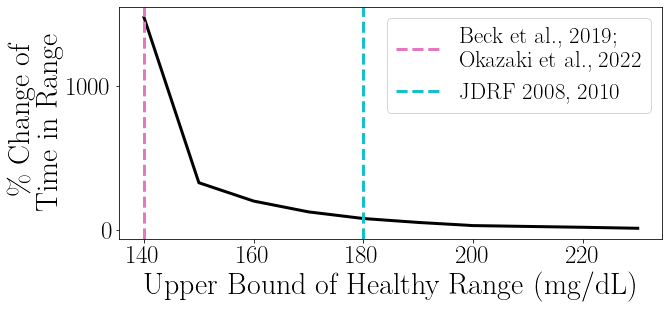

In [16]:
# plt.subplots_adjust(bottom=.25, left=.25)

bounds_df = pd.DataFrame({'low' : low, 
                               'high' : high, 
                               'txeffect' : ratio_list,
                               'bound' : ['(' + str(low[_]) + ',' + str(high[_]) + ']' for _ in range(len(low))]}).query('low == 70').query('high >= 140')

# plt.plot(bounds_df.bound, bounds_df.txeffect, linewidth = 3, color = 'black')
sns.lineplot(data = bounds_df, x = 'high', y = 'txeffect', color = 'black', linewidth = 3)
# plt.axhline(y = 0, linestyle = '--', color = 'black')


plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)


plt.xlabel(r'Upper Bound of Healthy Range (mg/dL)', size = 30)
plt.ylabel(r'\% Change of\\Time in Range', size = 30)

plt.axvline(x = 140, color = '#E377C2FF', linestyle = 'dashed', label = 'Beck et al., 2019;\nOkazaki et al., 2022', linewidth = 3)
plt.axvline(x = 180, color = '#17BECFFF', linestyle = 'dashed', label = 'JDRF 2008, 2010', linewidth = 3)
plt.legend(fontsize = 23)
plt.tight_layout()
plt.rcParams["figure.figsize"] = (10,4)


# plt.savefig('./cgm_analysis/plots/bounds_effect_lower70.png', dpi = 300, bbox_inches = 'tight', transparent = True)

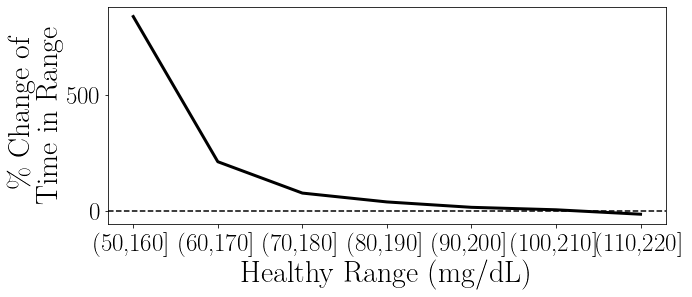

In [17]:
# plt.subplots_adjust(bottom=.25, left=.25)

bounds_df = pd.DataFrame({'low' : low, 
                               'high' : high, 
                               'txeffect' : ratio_list,
                               'bound' : ['(' + str(low[_]) + ',' + str(high[_]) + ']' for _ in range(len(low))]}).query('high == low + 110')

plt.plot(bounds_df.bound, bounds_df.txeffect, linewidth = 3, color = 'black')
plt.axhline(y = 0, linestyle = '--', color = 'black')

plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)


plt.xlabel(r'Healthy Range (mg/dL)', size = 30)
plt.ylabel(r'\% Change of\\Time in Range', size = 30)

plt.rcParams["figure.figsize"] = (10,5)

# plt.savefig('./cgm_analysis/plots/bounds_effect.png', dpi = 300, bbox_inches = 'tight', transparent = True)

## Dist Input/Outcome MALTS

In [18]:
# # # # run MALTSPro
# np.random.seed(999)
# maltspro = pmp.pymaltspro(X = X_train,
#                             y = y_train, 
#                             y_qtl_id=True,
#                             X_quantile_fns=Q_x_train,
#                             treatment = 'Treatment', 
#                             discrete = [],
#                             C = 0.75,
#                             k = 5)


In [19]:
# np.random.seed(999)
# maltspro.fit(method = 'COBYLA')

In [20]:
# pkl_file = open('./cgm_analysis/maltspro_model_cobyla.pkl', 'wb')
# pkl.dump(maltspro, file = pkl_file)

In [21]:
pkl_file = open('./cgm_analysis/maltspro_model_cobyla.pkl', 'rb')
maltspro = pkl.load(pkl_file)

In [22]:
(maltspro.M_opt/maltspro.M_opt.values.sum())

,SevHypo,EduCollegeGrad,low_baseline_hba1c,NonHispanicWhite,Male,AgeAsOfRandDt,DurDiabetes,0
Diag,0.175445,0.049383,0.052855,0.167189,0.276424,0.042897,0.023236,0.212572


In [23]:
# get matched groups
MG = maltspro.get_matched_groups(X_estimation=X_est, X_qtl_estimation=Q_x_est, Y_estimation=y_est, k = 5)
# impute counterfactual
y_bary = maltspro.barycenter_imputation(X_estimation=X_est, Y_estimation=y_est, MG = MG, qtl_id=True)
# reference distribution is just quantiles
reference_distribution = np.vstack([qtl_grid,
                                    qtl_grid])
# get cate for each individual
ITE = []
for i in range(X_est.shape[0]):
    ITE.append(CATE(y_obs = y_est[i, :],
                         y_cf=y_bary[i, :], 
                         observed_treatment=X_est['Treatment'].values[i], 
                        #  reference_distribution=reference_distribution,
                         y_obs_qtl_id = True,
                         y_cf_qtl_id = True)[1, :])
ITE = np.array(ITE)

## Plots

In [24]:
sns.set_theme(style = 'whitegrid')
sns.set(rc = {'figure.figsize':(14,6)})
sns.set(font_scale = 1.75)

In [25]:
# # plot quantile functions for specific subpopulations
sns.set_theme(font_scale=1)
from scipy.special import ndtri
def plots(unit_ids, maltspro = maltspro, alpha = 0.05):
    i = 22
    # plt.plot(reference_distribution[0, i:-i], control_outcome[unit_ids, i:-i].mean(axis = 0).reshape(-1, 1), label = 'control')
    # plt.plot(reference_distribution[0, i:-i], treated_outcome[unit_ids, i:-i].mean(axis = 0).reshape(-1, 1), label = 'treated')
    # plt.legend()
    # plt.show()

    # # plot ITE plot for specific subpopulation
    CATE = ITE[unit_ids, i:-i].mean(axis = 0)


    # CATE_hi, CATE_low = variance_estimate(mg_df = MG.loc[MG['unit'].isin(unit_ids)], 
    #                                       mp_model = maltspro, 
    #                                       X_est = X_est, 
    #                                       y_est_qtl = y_est,
    #                                       X_est_qtl = Q_x_est,
    #                                       k = 5,
    #                                       wrf_control = wrf_control,
    #                                       wrf_treated = wrf_treated)
    
    plt.plot(reference_distribution[0, i:-i], CATE, label = 'ADD MALTS pre-pruned')
    # plt.fill_between(reference_distribution[0, i:-i], CATE_hi[i:-i], CATE_low[i:-i], color = 'gray', alpha = 0.2)
    plt.axhline(y = 0, linestyle = '--', color = 'black')
    # plt.axhline(y = CATE_malts[unit_ids].mean(), linestyle = '--', color = 'red', label = 'Scalar MALTS')
    # plt.axhline(y = ITE[unit_ids, 450].mean(), linestyle = '--', color = 'orange', label = 'Diff in Medians')
    # plt.title(f'Scalar MALTS diff in TIR: {CATE_malts[unit_ids].mean()}')

from pymaltspro import sample_quantile
def plot_density(unit_ids, title, maltspro = maltspro):
    Y1 = np.squeeze(np.asarray(treated_outcome[0, :].mean(axis = 0).reshape(treated_outcome.shape[1])))
    Y0 = np.squeeze(np.asarray(control_outcome[0, :].mean(axis = 0).reshape(control_outcome.shape[1])))
    qtls = np.random.uniform(0, 1, size = int(1e6)).reshape(-1,1)
    np.random.seed(12345)
    Y1_samples = np.array([sample_quantile(Y1, i) for i in qtls])
    Y0_samples = np.array([sample_quantile(Y0, i) for i in qtls])
    sns.set_theme(style = 'whitegrid')
    sns.set(rc = {'figure.figsize':(14,6)})
    sns.set(font_scale = 1.75)
    pd.DataFrame({'Standard Monitoring' : Y0_samples,
              'CGM Monitoring' : Y1_samples}).boxplot(showfliers = False)
    plt.ylabel('Distribution of Glucose Level')
    plt.title(title)
    plt.show()

## Post-pruning MALTS results

In [26]:
# plt.plot(qtl_grid, y_est[np.where(X_est.Treatment == 1)[0], :].mean(axis = 0) - y_est[np.where(X_est.Treatment == 0)[0], :].mean(axis = 0))
# plt.plot(qtl_grid, y[np.where(demographic_data.Treatment == 1)[0], :].mean(axis = 0) - y[np.where(demographic_data.Treatment == 0)[0], :].mean(axis = 0))

In [27]:
sevHypo_list = []
for i in MG.loc[MG['SevHypo'] == True, ].unit.unique():
    sevHypo_list.append(MG.\
    query(f'unit == {i}').\
        query('Treatment != unit_treatment').SevHypo.mean())

In [28]:
MG.\
    query('unit == 276').\
        query('matched_unit == 276 | Treatment != unit_treatment')[['unit'] + ['matched_unit'] + [maltspro.continuous[i] for i in (-1 * maltspro.Mc).argsort()] + ['distance', 'Treatment']].\
            sort_values(['distance'], ascending = True).\
                reset_index().\
                    drop(['index', 'unit', 'distance'], axis = 1).\
                            to_latex('./cgm_analysis/overlap_table.tex', escape = False, column_format = 'p{1.5cm}|' * 9, index = False)


In [29]:
MG.\
    query('unit == 276').\
        query('matched_unit == 276 | Treatment != unit_treatment')[['unit'] + ['matched_unit'] + [maltspro.continuous[i] for i in (-1 * maltspro.Mc).argsort()] + ['distance', 'Treatment']].\
            sort_values(['distance'], ascending = True).\
                reset_index().\
                    drop(['index', 'unit', 'distance'], axis = 1)

,matched_unit,Male,SevHypo,NonHispanicWhite,low_baseline_hba1c,EduCollegeGrad,AgeAsOfRandDt,DurDiabetes,Treatment
0,276,True,True,True,True,True,43,24.3,0
1,277,True,False,True,False,True,42,20.3,1
2,0,False,False,True,True,True,36,29.8,1
3,331,False,False,True,False,True,40,24.2,1
4,233,False,False,True,False,True,40,33.1,1
5,151,False,False,True,False,True,49,35.4,1


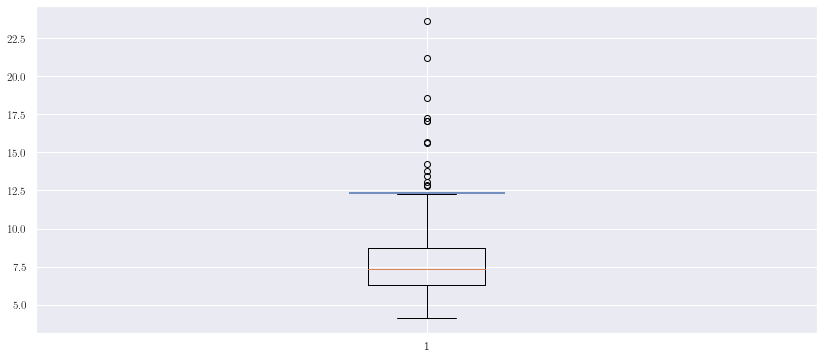

In [30]:
avg_distances = MG.query('unit_treatment != Treatment').groupby('unit').distance.mean()
upper_bwr = np.quantile(avg_distances, 0.75) + 1.5 * (np.quantile(avg_distances, 0.75) - np.quantile(avg_distances, 0.25))
plt.boxplot(avg_distances)
plt.hlines(y = upper_bwr, xmin = 0.9, xmax = 1.1)
keep_or_not = avg_distances <= upper_bwr
keep_ids = avg_distances[np.where(keep_or_not == 1)[0]].index.values
MG_pruned = MG.loc[MG['unit'].isin(keep_ids)]


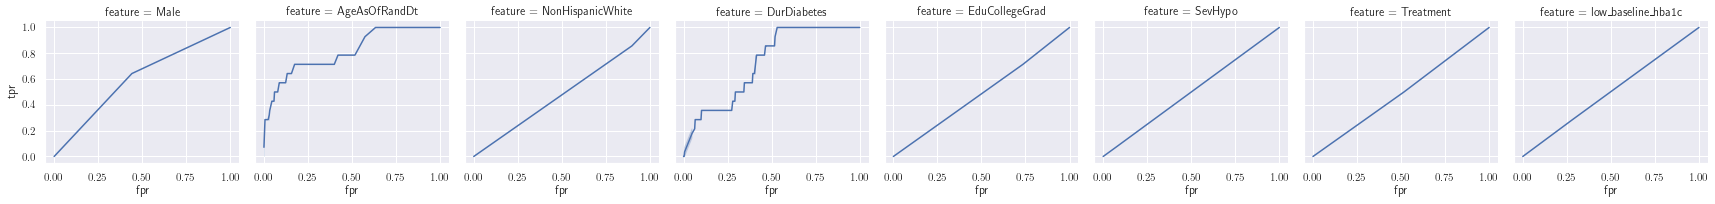

In [31]:
from sklearn.metrics import roc_curve
tpr = []
fpr = []
feature = []

for col in X_est.columns:
    tpr_col, fpr_col, thresh_col = roc_curve(keep_or_not, X_est[col].values, pos_label = 1)
    tpr = np.concatenate([tpr, tpr_col])
    fpr = np.concatenate([fpr, fpr_col])
    feature = np.concatenate([feature, np.array([col for _ in range(len(tpr_col))])])
roc_df = pd.DataFrame({'fpr' : fpr, 'tpr' : tpr, 'feature' : feature})

g = sns.FacetGrid(roc_df, col = 'feature')
g.map(sns.lineplot, 'fpr', 'tpr')

In [32]:
def MG_pruned_CATE_plot(unit_ids, keep_ids, keep_ids_scalar, maltspro = maltspro, alpha = 0.05):
    i = 22
    unit_ids = np.intersect1d(unit_ids, keep_ids)
    unit_ids_scalar = np.intersect1d(unit_ids, keep_ids_scalar)
    # plt.plot(reference_distribution[0, i:-i], control_outcome[unit_ids, i:-i].mean(axis = 0).reshape(-1, 1), label = 'Control Outcome')
    # plt.plot(reference_distribution[0, i:-i], treated_outcome[unit_ids, i:-i].mean(axis = 0).reshape(-1, 1), label = 'Treated Outcome')
    # plt.legend()
    # plt.show()

    # # # plot ITE plot for specific subpopulation
    CATE = ITE[unit_ids, i:-i].mean(axis = 0)
    # # CATE_var = ((ITE[unit_ids, i:-i] - CATE)**2).mean(axis = 0)/2
    # # r = 1/(2 + maltspro.p)
    # # q = ndtri(1 - alpha/2)
    # # std_err = np.sqrt(CATE_var/(len(unit_ids)**r))
    # # CATE_CI_low = CATE -  q * std_err
    # # CATE_CI_high = CATE +  q * std_err
    plt.plot(reference_distribution[0, i:-i], CATE, label = 'ADD MALTS pruned')
    # # plt.fill_between(reference_distribution[0, i:-i], CATE_CI_low, CATE_CI_high, color = 'gray', alpha = 0.2)
    plt.axhline(y = 0, linestyle = '--', color = 'black')
    # # plt.axhline(y = CATE_malts[unit_ids].mean(), linestyle = '--', color = 'red', label = 'Scalar MALTS')
    # # plt.axhline(y = ITE[unit_ids, 450].mean(), linestyle = '--', color = 'orange', label = 'Diff in Medians')
    # plt.show()

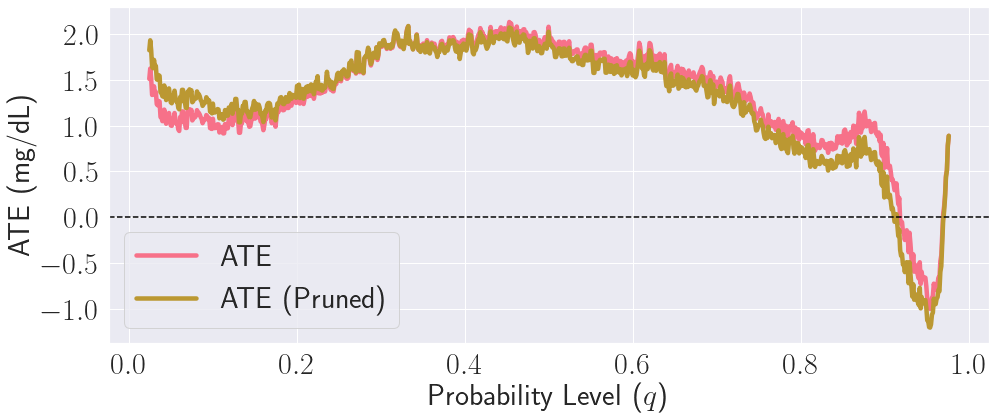

In [33]:
i = 22
unit_ids = np.where(X_est['AgeAsOfRandDt'] >= 0)[0]

# plot overall ATE
ATE = ITE[unit_ids, i:-i].mean(axis = 0)

# plot pruned ATE
unit_ids = np.intersect1d(np.where(X_est['AgeAsOfRandDt'] >= 0), keep_ids)

# plot CATE plot for specific subpopulation
ATE_pruned = ITE[unit_ids, i:-i].mean(axis = 0)

with sns.color_palette("husl"):
    plt.plot(reference_distribution[0, i:-i], ATE, label = 'ATE', linewidth = 4.5)
    plt.plot(reference_distribution[0, i:-i], ATE_pruned, label = 'ATE (Pruned)', linewidth = 4.5)

plt.legend(prop = {'size' : 30})
plt.axhline(y = 0, linestyle = '--', color = 'black')

plt.xticks(fontsize = 30, weight = 'bold')
plt.yticks(fontsize = 30, weight = 'bold')

plt.xlabel('Probability Level ($q$)', size = 30, weight = 'bold')
plt.ylabel('ATE (mg/dL)', size = 30)

plt.tight_layout()

# plt.savefig('./cgm_analysis/plots/ate.png', dpi = 300, transparent = True, bbox_inches='tight')

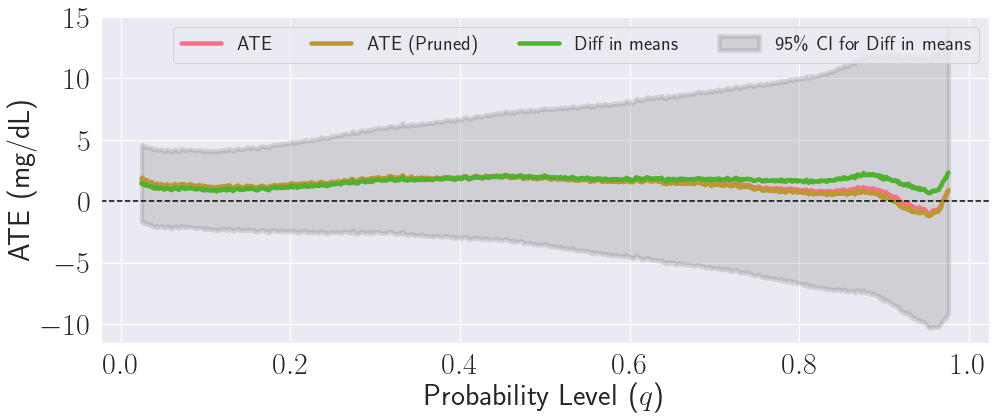

In [34]:
i = 22
unit_ids = np.where(X_est['AgeAsOfRandDt'] >= 0)[0]

# plot overall ATE
ATE = ITE[unit_ids, i:-i].mean(axis = 0)

# plot pruned ATE
unit_ids = np.intersect1d(np.where(X_est['AgeAsOfRandDt'] >= 0), keep_ids)

# plot CATE plot for specific subpopulation
ATE_pruned = ITE[unit_ids, i:-i].mean(axis = 0)

# diff in means CI
diff_in_means = y_est[np.where(X_est.Treatment == 1)[0], :].mean(axis = 0) - y_est[np.where(X_est.Treatment == 0)[0], :].mean(axis = 0)
treated_var = y_est[np.where(X_est.Treatment == 1)[0], :].var(axis = 0)
treated_n = y_est[np.where(X_est.Treatment == 1)[0], :].shape[0]
control_var = y_est[np.where(X_est.Treatment == 0)[0], :].var(axis = 0)
control_n = y_est[np.where(X_est.Treatment == 0)[0], :].shape[0]
diff_in_means_ci_lower = diff_in_means - 1.96 * np.sqrt(treated_var/treated_n + control_var/control_n)
diff_in_means_ci_upper = diff_in_means + 1.96 * np.sqrt(treated_var/treated_n + control_var/control_n)

with sns.color_palette("husl"):
    plt.plot(reference_distribution[0, i:-i], ATE, label = 'ATE', linewidth = 4.5)
    plt.plot(reference_distribution[0, i:-i], ATE_pruned, label = 'ATE (Pruned)', linewidth = 4.5)
    plt.plot(reference_distribution[0, i:-i], 
             (y_est[np.where(X_est.Treatment == 1)[0], :].mean(axis = 0) - y_est[np.where(X_est.Treatment == 0)[0], :].mean(axis = 0))[i:-i],
             label = 'Diff in means',
             linewidth = 4.5)
    plt.fill_between(reference_distribution[0, i:-i], 
                diff_in_means_ci_lower[i:-i],
                diff_in_means_ci_upper[i:-i],
                label = '95\% CI for Diff in means',
                alpha = 0.25,
                color = 'grey',
                linewidth = 4.5)
plt.legend(prop = {'size' : 20}, ncol = 4)
plt.axhline(y = 0, linestyle = '--', color = 'black')

plt.xticks(fontsize = 30, weight = 'bold')
plt.yticks(fontsize = 30, weight = 'bold')

plt.xlabel('Probability Level ($q$)', size = 30, weight = 'bold')
plt.ylabel('ATE (mg/dL)', size = 30)

plt.tight_layout()

plt.savefig('./cgm_analysis/plots/ate_ttest.png', dpi = 300, transparent = True, bbox_inches='tight')

Text(0, 0.5, 'CATE (mg/dL)')

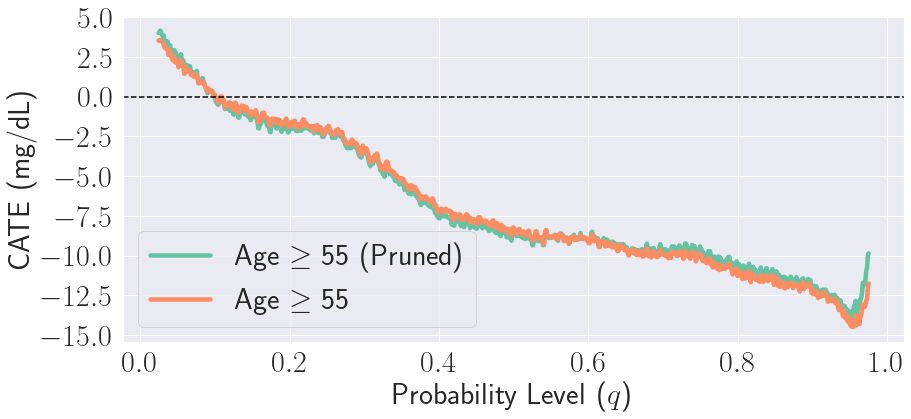

In [35]:
i = 22
unit_ids = np.where(X_est['AgeAsOfRandDt'] >= 55)[0]

# plot CATE >= 55
CATE_geq_55 = ITE[unit_ids, i:-i].mean(axis = 0)

# plot pruned CATE >= 55
unit_ids = np.intersect1d(np.where(X_est['AgeAsOfRandDt'] >= 55), keep_ids)

# plot CATE plot for specific subpopulation
CATE_pruned_geq_55 = ITE[unit_ids, i:-i].mean(axis = 0)

with sns.color_palette("Set2"):
    plt.plot(reference_distribution[0, i:-i], CATE_pruned_geq_55, label = r'Age $\geq$ 55 (Pruned)', linewidth = 4.5)
    plt.plot(reference_distribution[0, i:-i], CATE_geq_55, label = r'Age $\geq$ 55', linewidth = 4.5)
plt.legend(prop = {'size' : 30})
plt.axhline(y = 0, linestyle = '--', color = 'black')

plt.xticks(fontsize = 30)
plt.yticks(fontsize = 30)

plt.xlabel(r'Probability Level ($q$)', size = 30)
plt.ylabel(r'CATE (mg/dL)', size = 30)

# plt.savefig('./cgm_analysis/plots/cate_geq_55.png', dpi = 300, transparent = True, bbox_inches='tight')

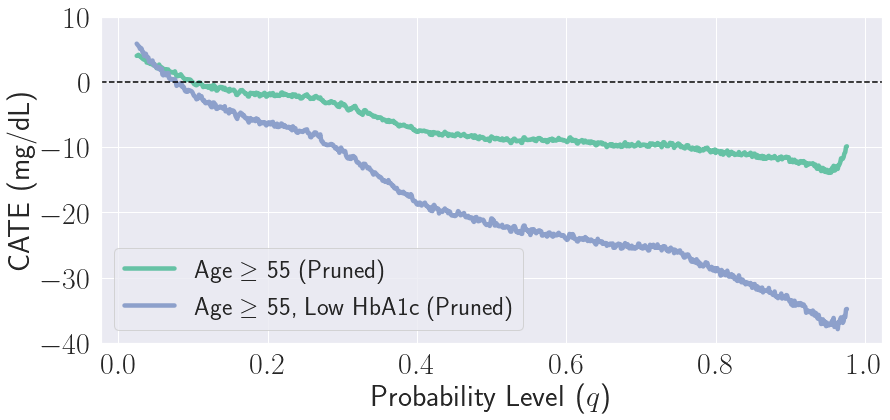

In [36]:
i = 22
unit_ids = np.intersect1d(np.where(X_est['AgeAsOfRandDt'] >= 55)[0], keep_ids)
# unit_ids_scalar = np.intersect1d(np.where(X_est['AgeAsOfRandDt'] >= 55)[0], keep_ids_scalar)

# plot CATE plot for specific subpopulation
CATE_age_geq_55_pruned = ITE[unit_ids, i:-i].mean(axis = 0)

unit_ids = np.intersect1d(np.intersect1d(np.where(X_est['low_baseline_hba1c'] == 1)[0], np.where(X_est['AgeAsOfRandDt'] >= 55)[0]), keep_ids)
# unit_ids_scalar = np.intersect1d(np.where(X_est['AgeAsOfRandDt'] >= 55)[0], keep_ids_scalar)

# plot CATE plot for specific subpopulation
CATE_age_geq_55_hba1c_pruned = ITE[unit_ids, i:-i].mean(axis = 0)

with sns.color_palette("Set2"):
    plt.plot(reference_distribution[0, i:-i], CATE_age_geq_55_pruned, label = 'Age $\geq$ 55 (Pruned)', linewidth = 4.5)
    plt.plot(reference_distribution[0, i:-i], np.zeros(reference_distribution[0, i:-i].shape[0]), label = None, linewidth = 0)
    # plt.plot(reference_distribution[0, i:-i], CATE_geq_55, label = r'Age $\geq$ 55', linewidth = 4.5)
    plt.plot(reference_distribution[0, i:-i], CATE_age_geq_55_hba1c_pruned, label = 'Age $\geq$ 55, Low HbA1c (Pruned)', linewidth = 4.5)
plt.legend(prop = {'size' : 25})
plt.axhline(y = 0, linestyle = '--', color = 'black')

plt.xticks(fontsize = 30)
plt.yticks(fontsize = 30)

plt.xlabel(r'Probability Level ($q$)', size = 30)
plt.ylabel(r'CATE (mg/dL)', size = 30)

plt.ylim(-40, 10)

plt.savefig('./cgm_analysis/plots/cate_low_hba1c_age_geq_55.png', dpi = 300, transparent = True, bbox_inches = 'tight')

N obs 309
N obs 24


Text(0, 0.5, 'CATE (mg/dL)')

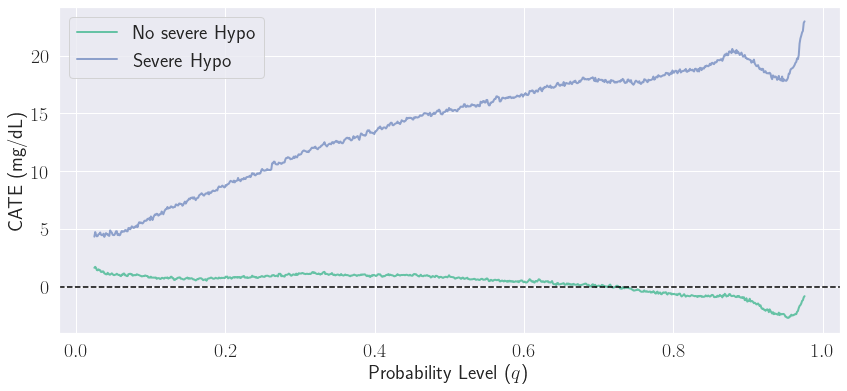

In [37]:
i = 22
# unit_ids = np.intersect1d(np.intersect1d(np.where(X_est['DurDiabetes'] <= 2)[0], np.where(X_est['AgeAsOfRandDt'] >= 55)[0]), keep_ids)
unit_ids = np.intersect1d(np.where(X_est['SevHypo'] == 0)[0], keep_ids)
print('N obs', unit_ids.shape[0])
# plot CATE plot for specific subpopulation
CATE_age_leq_18_pruned = ITE[unit_ids, i:-i].mean(axis = 0)

# unit_ids = np.intersect1d(np.intersect1d(np.where(X_est['DurDiabetes'] > 2)[0], np.where(X_est['AgeAsOfRandDt'] >= 55)[0]), keep_ids)
unit_ids = np.intersect1d(np.where(X_est['SevHypo'] == 1)[0], keep_ids)
print('N obs', unit_ids.shape[0])

# plot CATE plot for specific subpopulation
CATE_age_leq_18_college_pruned = ITE[unit_ids, i:-i].mean(axis = 0)

with sns.color_palette("Set2"):
    plt.plot(reference_distribution[0, i:-i], CATE_age_leq_18_pruned, label = 'No severe Hypo', linewidth = 2)
    plt.plot(reference_distribution[0, i:-i], np.zeros(reference_distribution[0, i:-i].shape[0]), label = None, linewidth = 0)
    plt.plot(reference_distribution[0, i:-i], CATE_age_leq_18_college_pruned, label = 'Severe Hypo', linewidth = 2)
plt.legend(prop = {'size' : 20})
plt.axhline(y = 0, linestyle = '--', color = 'black')

plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

plt.xlabel(r'Probability Level ($q$)', size = 20)
plt.ylabel(r'CATE (mg/dL)', size = 20)

N obs 215
N obs 118


Text(0, 0.5, 'CATE (mg/dL)')

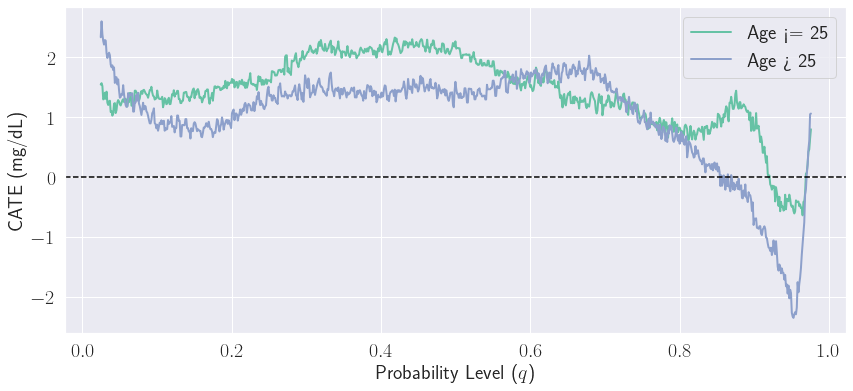

In [38]:
i = 22
# unit_ids = np.intersect1d(np.intersect1d(np.where(X_est['DurDiabetes'] <= 2)[0], np.where(X_est['AgeAsOfRandDt'] >= 55)[0]), keep_ids)
unit_ids = np.intersect1d(np.where(X_est['AgeAsOfRandDt'] <= 25)[0], keep_ids)
print('N obs', unit_ids.shape[0])
# plot CATE plot for specific subpopulation
CATE_age_leq_18_pruned = ITE[unit_ids, i:-i].mean(axis = 0)

# unit_ids = np.intersect1d(np.intersect1d(np.where(X_est['DurDiabetes'] > 2)[0], np.where(X_est['AgeAsOfRandDt'] >= 55)[0]), keep_ids)
unit_ids = np.intersect1d(np.where(X_est['AgeAsOfRandDt'] > 25)[0], keep_ids)
print('N obs', unit_ids.shape[0])

# plot CATE plot for specific subpopulation
CATE_age_leq_18_college_pruned = ITE[unit_ids, i:-i].mean(axis = 0)

with sns.color_palette("Set2"):
    plt.plot(reference_distribution[0, i:-i], CATE_age_leq_18_pruned, label = 'Age <= 25', linewidth = 2)
    plt.plot(reference_distribution[0, i:-i], np.zeros(reference_distribution[0, i:-i].shape[0]), label = None, linewidth = 0)
    plt.plot(reference_distribution[0, i:-i], CATE_age_leq_18_college_pruned, label = 'Age > 25', linewidth = 2)
plt.legend(prop = {'size' : 20})
plt.axhline(y = 0, linestyle = '--', color = 'black')

plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

plt.xlabel(r'Probability Level ($q$)', size = 20)
plt.ylabel(r'CATE (mg/dL)', size = 20)